#### Library import

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16082847477913560006
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12420831795965018985
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [8]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [9]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [10]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [11]:
As = data
Cd = data
Ni = data

In [12]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

#### Oversampling by SMOGN (SMOTE Regression)

In [13]:
import smogn

In [14]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme', k = 3)
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme', k = 7)

synth_matrix: 100%|##########| 242/242 [00:01<00:00, 161.95it/s]


In [15]:
As_smogn = As_smogn.reset_index(drop = True)
Cd_smogn = Cd_smogn.reset_index(drop = True)
Ni_smogn = Ni_smogn.reset_index(drop = True)

#### Eliminate outlier and train / test split

In [16]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [17]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [18]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [19]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [20]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1853, 15)
(1926, 15)
(2122, 15)


StandardScaler

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [385]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [386]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [22]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1482, 15)
(1540, 15)
(1697, 15)


#### 10-Fold Crossvalidation

In [388]:
# kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [23]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [24]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [29]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 16:04:50,880] A new study created in memory with name: svm_parameter_opt
[I 2023-08-30 16:04:51,457] Trial 0 finished with value: 0.4110510506552175 and parameters: {'C': 1.3034196763682784, 'epsilon': 0.08386262102260818, 'kernel': 'rbf', 'degree': 5}. Best is trial 0 with value: 0.4110510506552175.
[I 2023-08-30 16:04:51,879] Trial 1 finished with value: 0.34290556421879453 and parameters: {'C': 0.1379115321917602, 'epsilon': 0.12578323745344944, 'kernel': 'rbf', 'degree': 2}. Best is trial 0 with value: 0.4110510506552175.
[I 2023-08-30 16:04:52,471] Trial 2 finished with value: 0.4250728003053135 and parameters: {'C': 4.956166669242157, 'epsilon': 0.056135504829364836, 'kernel': 'rbf', 'degree': 3}. Best is trial 2 with value: 0.4250728003053135.
[I 2023-08-30 16:04:53,063] Trial 3 finished with value: -0.08028258954334755 and parameters: {'C': 12.515246606326302, 'epsilon': 0.4979269740977123, 'kernel': 'poly', 'degree': 2}. Best is trial 2 with value: 0.425072800305

Best r2:  0.452586133268154
Best trial: {'C': 5.226319322545693, 'epsilon': 0.3424926966012141, 'kernel': 'rbf', 'degree': 4}


In [30]:
optuna.visualization.plot_parallel_coordinate(study)

In [31]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 5.226319322545693, 'epsilon': 0.3424926966012141, 'kernel': 'rbf', 'degree': 4}


In [32]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=5.226319322545693, degree=4, epsilon=0.3424926966012141)

In [33]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [396]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [34]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.4618761102668297
Test RMSE:  0.501441428215157


In [35]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.6296846372246501
Test R2:  0.5898539091174195


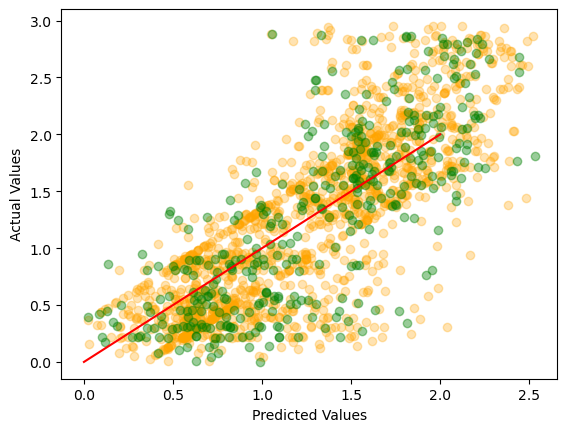

In [36]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

In [37]:
As_pred = pd.DataFrame(y_train_pred, columns = ['As_pred'])
As_pred_test = pd.DataFrame(y_test_pred, columns = ['As_pred'])

In [38]:
As_y_train = As_y_train.reset_index(drop = False)
As_y_test = As_y_test.reset_index(drop = False)

In [39]:
As_data = pd.concat([As_pred, As_y_train], axis = 1)
As_data_test = pd.concat([As_pred_test, As_y_test], axis = 1)

In [40]:
As_data.to_csv('SVM_As_train_data.csv', sep = ',')
As_data_test.to_csv('SVM_As_test_data.csv', sep = ',')

Cd

Optimization

In [25]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 16:20:32,679] A new study created in memory with name: svm_parameter_opt
[I 2023-08-30 16:20:32,702] Trial 0 finished with value: -0.8362142455943806 and parameters: {'C': 0.16729841387180783, 'epsilon': 0.7667608225442702, 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: -0.8362142455943806.
[I 2023-08-30 16:20:33,573] Trial 1 finished with value: 0.25572532349845956 and parameters: {'C': 0.5418593676352251, 'epsilon': 0.0710733922426741, 'kernel': 'linear', 'degree': 2}. Best is trial 1 with value: 0.25572532349845956.
[I 2023-08-30 16:20:33,810] Trial 2 finished with value: 0.1807316617155341 and parameters: {'C': 0.2818533366568711, 'epsilon': 0.24473406970793732, 'kernel': 'linear', 'degree': 1}. Best is trial 1 with value: 0.25572532349845956.
[I 2023-08-30 16:20:34,014] Trial 3 finished with value: 0.24037066380547184 and parameters: {'C': 0.1332322137809487, 'epsilon': 0.20537387005579105, 'kernel': 'linear', 'degree': 3}. Best is trial 1 with value: 0.

Best r2:  0.5253452925607937
Best trial: {'C': 2.07815338899397, 'epsilon': 0.056564344171193756, 'kernel': 'rbf', 'degree': 3}


In [26]:
optuna.visualization.plot_parallel_coordinate(study)

In [27]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 2.07815338899397, 'epsilon': 0.056564344171193756, 'kernel': 'rbf', 'degree': 3}


In [28]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=2.07815338899397, epsilon=0.056564344171193756)

In [29]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [30]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.12267563916446733
Test RMSE:  0.15377989193786404


In [31]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.7070989605432654
Test R2:  0.5756365892537234


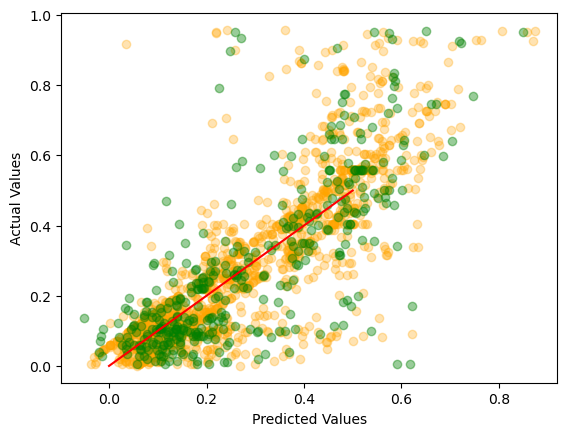

In [32]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

In [33]:
Cd_pred = pd.DataFrame(y_train_pred, columns = ['Cd_pred'])
Cd_pred_test = pd.DataFrame(y_test_pred, columns = ['Cd_pred'])

In [34]:
Cd_y_train = Cd_y_train.reset_index(drop = False)
Cd_y_test = Cd_y_test.reset_index(drop = False)

In [35]:
Cd_data = pd.concat([Cd_pred, Cd_y_train], axis = 1)
Cd_data_test = pd.concat([Cd_pred_test, Cd_y_test], axis = 1)

In [37]:
Cd_data.to_csv('SVM_Cd_train_data.csv', sep = ',')
Cd_data_test.to_csv('SVM_Cd_test_data.csv', sep = ',')

Ni

In [38]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 16:34:39,579] A new study created in memory with name: svm_parameter_opt
[I 2023-08-30 16:34:40,328] Trial 0 finished with value: 0.5183162881715709 and parameters: {'C': 3.5990932665217894, 'epsilon': 0.022465609472597802, 'kernel': 'rbf', 'degree': 5}. Best is trial 0 with value: 0.5183162881715709.
[I 2023-08-30 16:34:41,079] Trial 1 finished with value: 0.5165805840690346 and parameters: {'C': 3.4594421276923004, 'epsilon': 0.013581994878910302, 'kernel': 'rbf', 'degree': 5}. Best is trial 0 with value: 0.5183162881715709.
[I 2023-08-30 16:34:42,786] Trial 2 finished with value: 0.008777217144086347 and parameters: {'C': 9.38279475110393, 'epsilon': 0.034033905697743186, 'kernel': 'poly', 'degree': 3}. Best is trial 0 with value: 0.5183162881715709.
[I 2023-08-30 16:34:43,138] Trial 3 finished with value: 0.3857200322759284 and parameters: {'C': 0.222713488899058, 'epsilon': 0.4829514439050827, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: 0.5183162881715

Best r2:  0.5741601106450235
Best trial: {'C': 17.520855820516907, 'epsilon': 0.2221688590069915, 'kernel': 'rbf', 'degree': 4}


In [39]:
optuna.visualization.plot_parallel_coordinate(study)

In [40]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 17.520855820516907, 'epsilon': 0.2221688590069915, 'kernel': 'rbf', 'degree': 4}


In [41]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=17.520855820516907, degree=4, epsilon=0.2221688590069915)

In [42]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [43]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.5785446770381696
Test RMSE:  0.7875235212231646


In [44]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.7668232044031189
Test R2:  0.5571266457675118


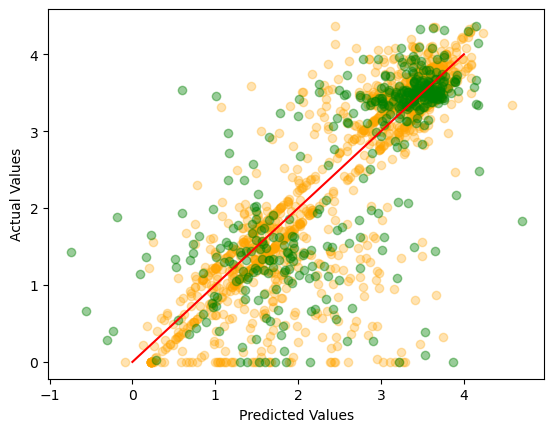

In [45]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()

In [46]:
Ni_pred = pd.DataFrame(y_train_pred, columns = ['Ni_pred'])
Ni_pred_test = pd.DataFrame(y_test_pred, columns = ['Ni_pred'])

In [47]:
Ni_y_train = Ni_y_train.reset_index(drop = False)
Ni_y_test = Ni_y_test.reset_index(drop = False)

In [48]:
Ni_data = pd.concat([Ni_pred, Ni_y_train], axis = 1)
Ni_data_test = pd.concat([Ni_pred_test, Ni_y_test], axis = 1)

In [49]:
Ni_data.to_csv('SVM_Ni_train_data.csv', sep = ',')
Ni_data_test.to_csv('SVM_Ni_test_data.csv', sep = ',')